## Account agent, PnL Agent, Risk management, and Datavisualization&RPA agent

In this notebook, I will explain the Account, PnL, and Risk management agents. Those are the back-office function in asset management company, and those agents work as the miniature of the middle office and back office function.

Also, I added PowerBI and RPA section here too, as one of the backoffice function. We can utilize Power BI and Power Automate to automate several tedious tasks.

## Setup

### Setup paths

* Add necessary imports for Google Drive which will be the working directory.
* Change the paths according to where your dataset is.

In [ ]:
from google.colab import drive
import sys, os

#mount google drive
drive.mount('/content/drive', force_remount=False)
# Change folder path so it corresponds to your environment
#COLAB_PATH = '/content/drive/My Drive/'
# change directory to the path above
#os.chdir(COLAB_PATH)

Mounted at /content/drive


### Install libraries

Install relevant libraries.

In [ ]:
!pip install pymysql

     |████████████████████████████████| 43 kB 1.1 MB/s 


### Import libraries

In [ ]:
#libraries for general purpose
import requests
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import calendar
import warnings
import json
import seaborn as sns
from sqlalchemy import create_engine
warnings.filterwarnings(action='ignore')

In [ ]:
#libraries for risk management agent
from scipy.stats import norm

### Create sql alchemy engine

It is used to establish the access to the NUS data library. Regarding NUS data library, please ask to Reshma who is the manager of the database. About the details, pls ask to the administrator of data library at Fintech Lab.

In [ ]:
# create sqlalchemy engine
sqlEngine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"
                       .format(user="xxxxxx",
                               pw="xxxxxx",
                               db="xxxxxx",
                               host = 'xxx.xxx.xxx.xxx',
                               port = xxxxx))

## Account/NAV management agent

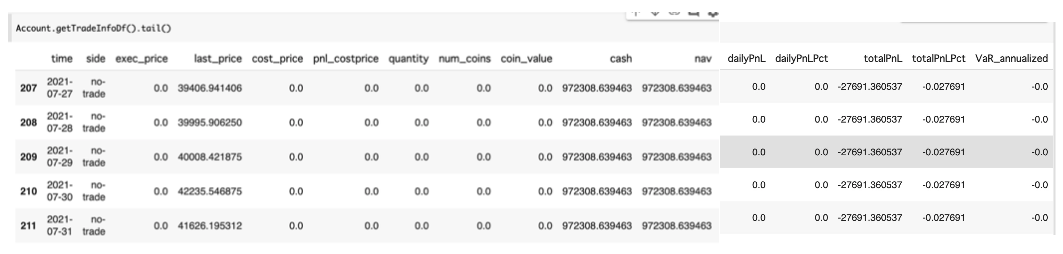

Account agent creates and maintains the account book shown above (Account.trade_info_df). It records daily trading activity (buy/sell/no-trade), purchased/sold price, # of bitcoin holding, NAV (net asset value = cash amount + market value of holding bitcoin), daily PnL, and annualized Value at Risk (VaR), etc. We can regard Account agent as the miniature of the back-office function in asset management companies.


### Code of the agent

In [ ]:
class Account(object):

  #Launch initial starting status of account.
  @staticmethod
  def initialization(num_coins, cash, time):
    Account.num_coins = num_coins
    Account.cash = cash
    #trading symbol used for hitbtc data acquisition
    Account.trading_symbol_hitbtc = 'BTC/USDT'
    #trading symbol used for yahoo data acquisition
    Account.trading_symbol_yahoo = 'BTC-USD'

    Account.trade_info_df = pd.DataFrame(data=[[time, 'no-trade',0,
                                                0, 0, 0,0, num_coins, 0,
                                                cash, cash,
                                                0,0,0,0,0]], 
                                      columns=['time','side', 'exec_price',
                                               'last_price','cost_price','pnl_costprice','quantity', 'num_coins', 
                                               'coin_value', 'cash', 'nav', 'dailyPnL',
                                               'dailyPnLPct','totalPnL', 'totalPnLPct','VaR_annualized'])
  
  @staticmethod
  def getCoins():
    return Account.num_coins
  
  @staticmethod
  def getCash():
    return Account.cash

  @staticmethod
  def setCoins(num_coins):
    Account.num_coins = num_coins

  @staticmethod
  def setCash(cash):
    Account.cash = cash

  #Trade execution can be done by Broker agent.
  #NAV, daily PnL and dailyPnLPct are calculated by PNLAgent.
  @staticmethod
  def recordNewTradeInfo(time, side, exec_price, last_price, cost_price, pnl_costprice,
                         quantity, num_coins, coin_value, cash, nav,dailyPnL, dailyPnLPct,
                         totalPnL, totalPnLPct, VaR_annualized):
    Account.setCoins(num_coins)
    Account.setCash(cash)
    Account.new_trade_info_df = pd.DataFrame(data=[[time, side, exec_price, 
                                                    last_price, cost_price, pnl_costprice,quantity, 
                                                    num_coins, coin_value, cash,
                                                    nav, dailyPnL, dailyPnLPct,
                                                    totalPnL, totalPnLPct, VaR_annualized]], 
                                  columns=Account.trade_info_df.columns)
    Account.trade_info_df = pd.concat([Account.trade_info_df, Account.new_trade_info_df], 
                                   axis=0).reset_index(drop=True)

  @staticmethod
  #NAV, daily PnL and dailyPnLPct are calculated by PNLAgent.
  def updateNoTradeDay(time, exec_price, last_price):
    time = time
    side = 'no-trade'
    exec_price = exec_price
    quantity = 0
    num_coins = Account.trade_info_df['num_coins'].iloc[-1]
    cost_price = Account.trade_info_df['cost_price'].iloc[-1]

    if cost_price == 0:
      pnl_costprice = 0
    else:
      pnl_costprice = last_price / cost_price - 1

    coin_value = last_price * num_coins
    cash = Account.trade_info_df['cash'].iloc[-1]
    #nav, pnl, and VaR are calculated later and we can leave those as zero here
    nav = 0.0
    dailyPnL = 0.0
    dailyPnLPct = 0.0
    totalPnL = 0.0
    totalPnLPct = 0.0
    VaR_annualized = 0.0

    no_trade_info_df = pd.DataFrame(data=[[time, side, exec_price, last_price, cost_price, 
                                           pnl_costprice,quantity, num_coins, coin_value, cash, 
                                           nav, dailyPnL, dailyPnLPct,
                                           totalPnL, totalPnLPct, VaR_annualized]], 
                                  columns=Account.trade_info_df.columns)
    Account.trade_info_df = pd.concat([Account.trade_info_df, no_trade_info_df], 
                                   axis=0).reset_index(drop=True)

  ########################
  #Getter functions
  ########################

  #Those can become interface
  #for communication among
  #different agents

  @staticmethod
  def getInitialCoins():
    return float(Account.trade_info_df['num_coins'].values[0])

  @staticmethod
  def getInitialCash():
    return float(Account.trade_info_df['cash'].values[0])

  @staticmethod
  def getTradeInfoDf():
    return Account.trade_info_df

### Example of execution of the Account agent

* Basically, Account agent just create and maintain the account book of Account.trade_info_df.

* Therefore, you will find that the detailed calculation of NAV, VaR, and trading transactions etc are not done correctly yet.

* Other agents such as Broker, PnL, and Risk management agents can take part of those calculation.

#### Account set-up

In [ ]:
Account.initialization(0,1000000,datetime.datetime(2021,1,1))

In [ ]:
Account.getTradeInfoDf()

,time,side,exec_price,last_price,cost_price,pnl_costprice,quantity,num_coins,coin_value,cash,nav,dailyPnL,dailyPnLPct,totalPnL,totalPnLPct,VaR_annualized
0,2021-01-01,no-trade,0,0,0,0,0,0,0,1000000,1000000,0,0,0,0,0


#### Trading execution (price and all other input and calculation are given by Broker and PnL agents)

In [ ]:
time = datetime.datetime(2021,1,2)
side = 'buy'
exec_price = 32800
last_price = 32900
cost_price = 32800
pnl_costprice = 32900/32800 - 1
quantity = 2
num_coins = 2
coin_value = 32900*2
cash = 1000000 - quantity * exec_price
nav = cash + coin_value
dailyPnL = 0
dailyPnLPct = 0
totalPnL = 0
totalPnLPct = 0
VaR_annualized = 0.1

In [ ]:
Account.recordNewTradeInfo(time, side, exec_price, last_price, cost_price, pnl_costprice,
                         quantity, num_coins, coin_value, cash, nav,dailyPnL, dailyPnLPct,
                         totalPnL, totalPnLPct, VaR_annualized)

In [ ]:
Account.getTradeInfoDf()

,time,side,exec_price,last_price,cost_price,pnl_costprice,quantity,num_coins,coin_value,cash,nav,dailyPnL,dailyPnLPct,totalPnL,totalPnLPct,VaR_annualized
0,2021-01-01,no-trade,0,0,0,0.000000,0,0,0,1000000,1000000,0,0,0,0,0.0
1,2021-01-02,buy,32800,32900,32800,0.003049,2,2,65800,934400,1000200,0,0,0,0,0.1


#### No trade (Detailed calculation can be done by other agents)

In [ ]:
time = datetime.datetime(2021,1,3)
exec_price = 0
last_price = 34100

In [ ]:
Account.updateNoTradeDay(time, exec_price, last_price)

In [ ]:
Account.getTradeInfoDf()

,time,side,exec_price,last_price,cost_price,pnl_costprice,quantity,num_coins,coin_value,cash,nav,dailyPnL,dailyPnLPct,totalPnL,totalPnLPct,VaR_annualized
0,2021-01-01,no-trade,0,0,0,0.000000,0,0,0,1000000,1000000.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-02,buy,32800,32900,32800,0.003049,2,2,65800,934400,1000200.0,0.0,0.0,0.0,0.0,0.1
2,2021-01-03,no-trade,0,34100,32800,0.039634,0,2,68200,934400,0.0,0.0,0.0,0.0,0.0,0.0


## Broker agent

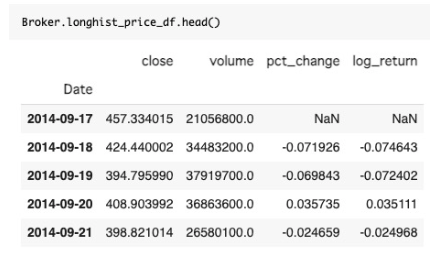

Broker agent handles market data acquisition and buy/sell trading execution.

* **1.Market data acquisition**
 
 In terms of collecting market information, Broker class has the ability to get both historical and real time cryptocurrency price and trade information. When I started the system development, I gathered price data from yahoo finance and market exchange such as hitbtc using ccxt library. Then, NUS Fintech Lab decided to launch a SQL data library, such that I implemented a broker agent such that the system obtains data from MySQL data library. So far, this data library obtains daily OHLCV (Open-High-Low-Close-Volume) data from yahoo finance. 

 (Note: Through market exchanges using ccxt, we can obtain only recent data from around 2017. On the other hand, we can obtain bitcoin OHLCV data from 2014 by yahoo finance. For daily market analysis, at least we need 5-6 years of data. With such a background, yahoo finance is used as the data source this time.)

 Broker agent maintains price data as Broker.longhist_price_df shown below. The system only uses closing prices, such that this dataframe just stores closing price data and daily volume. Then, the system adds day to day percent change and log-return too.
 
 (Note: For back-test purposes, industry practitioners often use log return, because it’s easy to calculate cumulative return just by adding daily log return.)

* **2.Trading execution**

 In terms of executing decisions, Broker agent has the ability to initialize the trade information stored in the Account Class, execute the trade according to the final decision made by the CEO agent, and update the account information.

 With regard to the trading execution, as the simulation logic, the system assumed 0.1% of spread from closing price, i.e. we need to buy 0.1% higher than market close, while we need to sell 0.1% lower than market price. In the future, if NUS Fintech Lab establishes simulated market exchange or directly trades real money at market exchange, a successor can modify Broker agent by which the system enables us to buy/sell at the simulated or real market exchange.



### Code of the agent

In [ ]:
class Broker(object):

  #get whole price from SQL data library.
  @staticmethod
  def getPriceFromDataLibrary():
    dbConnection = sqlEngine.connect()
    price_df = pd.read_sql("select * from YahooData", dbConnection)
    dbConnection.close()

    price_df = price_df.set_index('Date')[['Close','Volume']]
    price_df.columns = ['close','volume']
    return price_df

  #get price data from yahoo finance
  #just for your reference. After we implemented getPriceFromDataLibrary(),
  #we don't use this function.
  '''
  @staticmethod
  def get_yahoo_hist_ohlcv_data(ticker, startday, endday):
    ohlcv_df = yfinance.download(ticker, start=startday, end=endday)\
                  .drop('Adj Close',axis=1)
    ohlcv_df['currency'] = ticker
    ohlcv_df = ohlcv_df[['currency','Open','High','Low','Close','Volume']]
    ohlcv_df.index = ohlcv_df.index.astype('datetime64[ns]')
    ohlcv_df.columns = ['currency','open','high','low','close','volume']
    # Data cleaning (if nan, fill in by previous day's price)
    ohlcv_df = ohlcv_df.fillna(method='ffill')
  
    return ohlcv_df
  '''

  @staticmethod
  def addPctChg(df):
    df = df.copy()
    #calculate % changes
    df['pct_change'] = df['close'].pct_change()
    #In the backtesting, log return is useful, because we can calculate accumulate return %
    #just by adding daily return %. np.log1p calculate log(1+x)
    df['log_return'] = np.log1p(df['pct_change'])

    return df

  @staticmethod
  def histPriceAcquisition():
    longhist_price_df = Broker.getPriceFromDataLibrary()
    #add pct change and log_return
    longhist_price_df = Broker.addPctChg(longhist_price_df)

    #assure all 365 days are within the data index.
    startday = longhist_price_df.index[0]
    endday = longhist_price_df.index[-1]

    date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
    date_df = pd.DataFrame(date_index)
    date_df.columns = ['Date']
    date_df['Date'] = pd.to_datetime(date_df['Date']) 
    longhist_price_df = longhist_price_df.reset_index()
    longhist_price_df = date_df.merge(longhist_price_df, on='Date', how='outer')
    #change datetype of Date
    longhist_price_df['Date'] = longhist_price_df['Date'].astype("datetime64")
    #executing ffill (if no price is available, just filling by previous price data)
    longhist_price_df = longhist_price_df.fillna(method='ffill')
    longhist_price_df = longhist_price_df.set_index('Date')

    #Broker.longhist_price_df is created under Broker class.
    Broker.longhist_price_df = longhist_price_df[['close','volume','pct_change','log_return']]

  #Obtain trading start day from Account
  @staticmethod    
  def getInitialDay():
    initialDay = Account.getTradeInfoDf()['time'].iloc[0]
    return initialDay

  '''
  #########################
  #market data acquisition and execution from hitbtc.
  #Just for reference purpose.
  #After we implemented SQL data library, 
  #we don't use ccxt downloading function.
  #########################

  @staticmethod
  def get_ohlcv_data(trading_symbol_hitbtc, candlestick_timeframe, limit=100):
      ohlcv = Broker.hitbtc.fetch_ohlcv(trading_symbol_hitbtc, candlestick_timeframe, 
                                        limit=limit, params={'sort': 'DESC'})
      df = pd.DataFrame(ohlcv, columns=['Date', 'open', 'high', 'low', 'close', 'volume'])
      df['Date'] = df['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
      df.index = df.set_index('Date',drop=True).index.astype('datetime64[ns]')
      return df

  @staticmethod
  def get_mid_price(trading_symbol_hitbtc):
      ticker = Broker.hitbtc.fetch_ticker(trading_symbol_hitbtc)
      return ((float)(ticker['info']['bid']) + (float)(ticker['info']['ask']))/2

  @staticmethod
  def get_bid_price(trading_symbol_hitbtc):
      ticker = Broker.hitbtc.fetch_ticker(trading_symbol_hitbtc)
      return (float)(ticker['info']['bid'])

  @staticmethod
  def get_ask_price(trading_symbol_hitbtc):
      ticker = Broker.hitbtc.fetch_ticker(trading_symbol_hitbtc)
      return (float)(ticker['info']['ask'])

  #Place order at the current price, current time
  #nav, dailyPnL, dailyPnLPct are calculated by PnLAgent
  @staticmethod
  def tradeExecutionNow(side, quantity,nav, dailyPnL, dailyPnLPct, 
                        totalPnL,totalPnLPct, VaR_annualized):
    
    #when we buy, buy at ask price,
    #when we sell, sell at bid price.
    bid_price = Broker.get_bid_price(Account.trading_symbol_hitbtc)
    ask_price = Broker.get_ask_price(Account.trading_symbol_hitbtc)

    if side == 'buy':
      exec_price = ask_price
    elif side == 'sell':
      exec_price = bid_price
    
    time = Broker.getCurrentDate()

    Broker.tradeExecution(time,side, exec_price, quantity, nav, dailyPnL, 
                          dailyPnLPct, totalPnL,totalPnLPct, VaR_annualized)
  '''

  ###########################
  #Functions for pseudo bid/ask data acquisition
  #we set as follows:
  #bid price: close price minus 0.1%
  #ask price: close price plus 0.1%
  ###########################

  #pseudo price is used for simulation
  @staticmethod
  def get_pseudo_mid_price(day):
      return float(Broker.longhist_price_df.loc[day,'close'])

  #pseudo price is used for simulation
  @staticmethod
  def get_pseudo_bid_price(day, spread = 0.001):
      return float(Broker.longhist_price_df.loc[day, 'close']) * (1.0 - spread)


  #pseudo price is used for past simulation
  @staticmethod
  def get_pseudo_ask_price(day, spread=0.001):
      return float(Broker.longhist_price_df.loc[day,'close']) * (1.0 + spread)

  @staticmethod
  def getCurrentDate():
    return datetime.date.today()

  @staticmethod
  def getPseudoCurrentDate(index):
      return Broker.longhist_price_df.iloc[index]['time']

  # Place the order
  #nav, dailyPnL, dailyPnLPct are calculated by PnLAgent
  @staticmethod
  def tradeExecution(time,side, exec_price, quantity, nav, 
                     dailyPnL, dailyPnLPct, totalPnL,totalPnLPct, 
                     VaR_annualized):
      exec_price = float(exec_price)
      #last price is set as exec_price temporarilly.
      #After the execution of trade, last_price can be updated by PNLAgent.
      last_price_temp = float(exec_price)
      num_coins = Account.getCoins()
      cash = Account.getCash()
      if side == 'buy':
          if cash < exec_price*quantity:
              quantity = float(cash/exec_price)

          num_coins_old = num_coins
          cost_price_old = Account.getTradeInfoDf()['cost_price'].iloc[-1]
          num_coins = num_coins + quantity
          #cost price is the weighted average of new position of execution price and buying
          #quentiti, and existing position and cost price          
          cost_price = (exec_price * quantity + cost_price_old * num_coins_old) / num_coins
          cash = cash - exec_price*quantity
      elif side == 'sell':
          if num_coins < quantity:
              quantity = num_coins
          num_coins = num_coins - quantity
          cash = cash + exec_price*quantity
          #if selling all position, reset cost price
          if num_coins == 0:
            cost_price = 0
          else:
            cost_price = Account.getTradeInfoDf()['cost_price'].iloc[-1]
      #calculate current pnl % from cost price
      if cost_price == 0:
        pnl_costprice = 0
      else:
        pnl_costprice = last_price_temp / cost_price - 1

      #NAV is calculated by PNLAgent.
      coin_value = last_price_temp * num_coins
      Account.recordNewTradeInfo(time, side, exec_price, last_price_temp, cost_price, pnl_costprice,
                                 quantity, num_coins, coin_value, cash, nav, dailyPnL, 
                                 dailyPnLPct,totalPnL,totalPnLPct, VaR_annualized)

  ########################
  #Getter functions
  ########################

  #Those can become interface
  #for communication among
  #different agents
  @staticmethod
  def longHistoryPriceGetter():
    return Broker.longhist_price_df

### Example of execution of the Broker agent

#### price acquisition from SQL data library

In [ ]:
Broker.histPriceAcquisition()

In [ ]:
Broker.longHistoryPriceGetter().head()

,close,volume,pct_change,log_return
Date,,,,
2014-09-17,457.334015,21056800.0,NaN,NaN
2014-09-18,424.440002,34483200.0,-0.071926,-0.074643
2014-09-19,394.795990,37919700.0,-0.069843,-0.072402
2014-09-20,408.903992,36863600.0,0.035735,0.035111
2014-09-21,398.821014,26580100.0,-0.024659,-0.024968


#### Trading execution

* Broker.tradeExecution function operates buy/sell trading execution.

* Executed trade is booked on Account.trade_info_df, using the function of Account.recordNewTradeInfo() function which is implemented in the Account agent.

* You will find that still nav,dailyPnL,dailyPnLPct, totalPnL, totalPnLPct,	VaR_annualized are not calculated correctly. PnL agent and Risk management agent take part of calculating those figures.

In [ ]:
#those instruction are sent from CEO agent.
side = 'buy'
time = datetime.datetime(2021,1,4)
quantity = 3.5
#obtaining today's price
exec_price = Broker.get_pseudo_ask_price(time)

In [ ]:
#temporally set as zero. Those figures are calculated later 
#by PnL agent and Risk management agent
nav = 0.0
dailyPnL = 0.0
dailyPnLPct = 0.0
totalPnL = 0.0
totalPnLPct = 0.0
VaR_annualized = 0.0

In [ ]:
Broker.tradeExecution(time,side, exec_price, quantity, nav, 
                     dailyPnL, dailyPnLPct, totalPnL,totalPnLPct, 
                     VaR_annualized)

In [ ]:
Account.getTradeInfoDf()

,time,side,exec_price,last_price,cost_price,pnl_costprice,quantity,num_coins,coin_value,cash,nav,dailyPnL,dailyPnLPct,totalPnL,totalPnLPct,VaR_annualized
0,2021-01-01,no-trade,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1000000.000000,1000000.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-02,buy,32800.000000,32900.000000,32800.000000,0.003049,2.0,2.0,65800.000000,934400.000000,1000200.0,0.0,0.0,0.0,0.0,0.1
2,2021-01-03,no-trade,0.000000,34100.000000,32800.000000,0.039634,0.0,2.0,68200.000000,934400.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-04,buy,32003.885977,32003.885977,32293.381985,-0.008965,3.5,5.5,176021.372871,822386.399082,0.0,0.0,0.0,0.0,0.0,0.0


## PnL agent

Based on the raw data collected and recorded by the Account and Broker agent, PNL agent is the one who calculates and updates NAV and PnL information in the account book which is created and maintained by Account agent.


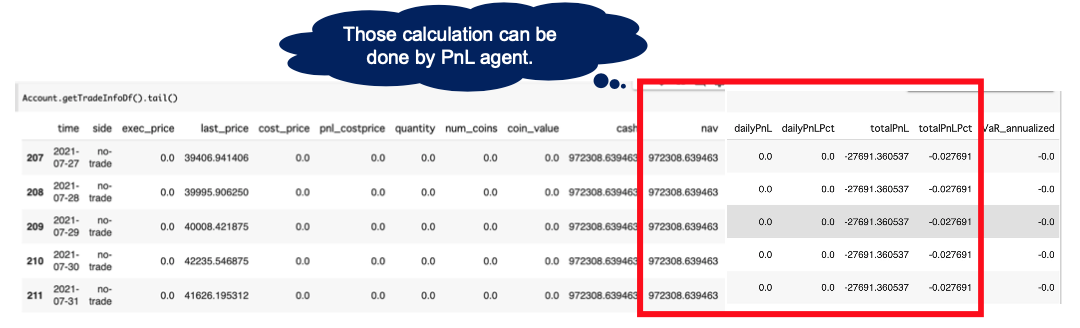

### Code of the agent

In [ ]:
class PNLAgent(object):

  ####################
  #Functions to get basic data
  ####################

  #Obtain trading start day from Account
  @staticmethod    
  def getInitialDay():
    PNLAgent.initialDay = Account.getTradeInfoDf()['time'].iloc[0]
    return PNLAgent.initialDay

  @staticmethod
  def getInitialNAV():
    return float(Account.getTradeInfoDf().loc[0, 'nav'])

  @staticmethod
  def getTodayNAV(day):
    indexRow = Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day].index.values[0]

    return float(Account.getTradeInfoDf().loc[indexRow, 'nav'])

  #Update daily last price
  @staticmethod
  def updateLastPrice(day):
    last_price = Broker.longHistoryPriceGetter().loc[day,'close']
    Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day,['last_price']] = last_price

    #update pnl_costprice after updating last price
    cost_price = Account.getTradeInfoDf()['cost_price'].iloc[-1]
    if cost_price == 0:
      pnl_costprice = 0
    else:
      pnl_costprice = last_price / cost_price - 1

    Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day,['pnl_costprice']] = pnl_costprice

  ####################
  #Compute Net Asset Value (NAV) and return
  ####################

  #compute daily nav
  #e.g. index = datetime.datetime(2021, 1, 2)
  @staticmethod
  def calculateNAV(day):

    indexRow = Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day].index.values[0]

    coins = Account.getTradeInfoDf().loc[indexRow,'num_coins']
    price = Account.getTradeInfoDf().loc[indexRow,'last_price']
    cash = Account.getTradeInfoDf().loc[indexRow, 'cash']
    coin_value = coins * price
    Account.getTradeInfoDf().loc[indexRow, 'coin_value'] = coin_value
    NAV = coin_value + cash
    Account.getTradeInfoDf().loc[indexRow, 'nav'] = NAV

    if indexRow == 0:
      Account.getTradeInfoDf().loc[indexRow, 'dailyPnL'] = 0
      Account.getTradeInfoDf().loc[indexRow, 'dailyPnLPct'] = 0.0
      Account.getTradeInfoDf().loc[indexRow, 'totalPnL'] = 0.0
      Account.getTradeInfoDf().loc[indexRow, 'totalPnLPct'] = 0.0

    else:
      Account.getTradeInfoDf().loc[indexRow, 'dailyPnL'] = Account.getTradeInfoDf().loc[indexRow, 'nav'] - \
              Account.getTradeInfoDf().loc[indexRow-1, 'nav']
      Account.getTradeInfoDf().loc[indexRow, 'dailyPnLPct'] = Account.getTradeInfoDf().loc[indexRow, 'dailyPnL'] / \
              Account.getTradeInfoDf().loc[indexRow-1, 'nav']
      Account.getTradeInfoDf().loc[indexRow, 'totalPnL'] = Account.getTradeInfoDf().loc[indexRow, 'nav'] - \
              Account.getTradeInfoDf().loc[0, 'nav']
      Account.getTradeInfoDf().loc[indexRow, 'totalPnLPct'] = Account.getTradeInfoDf().loc[indexRow, 'totalPnL'] / \
              Account.getTradeInfoDf().loc[0, 'nav']
      Account.getTradeInfoDf().loc[indexRow, 'VaR_annualized'] = riskManagement.portVaRCalc(day)

  #Compute total return since trading inception.
  @staticmethod
  def computePnLSinceInception():
    return (Account.getTradeInfoDf()['nav'].iloc[-1] - Account.getTradeInfoDf()['nav'].iloc[0])/ \
            Account.getTradeInfoDf()['nav'].iloc[0]

(Regarding the execution of PnL agent, we will do so after explaining risk management agent.)

## Risk management agent

I implemented an independent risk management agent, based on Value at Risk (VaR). 

Basically, institutional investors (i.e. such as hedge-fund) determine the position size based on "how much we can make loss". The legendary hedge-fund manager George Soros also mentioned this point as “Survival first, then make profit”. 

This chapter introduces the concept of VaR. The CEO agent will set the maximum limit of annualized 5% VaR, i.e. possible annual loss with 5% of probability as initial risk management policy. Then, the position size is determined based on this annualized VaR limit.

### 1.Value at Risk (VaR)

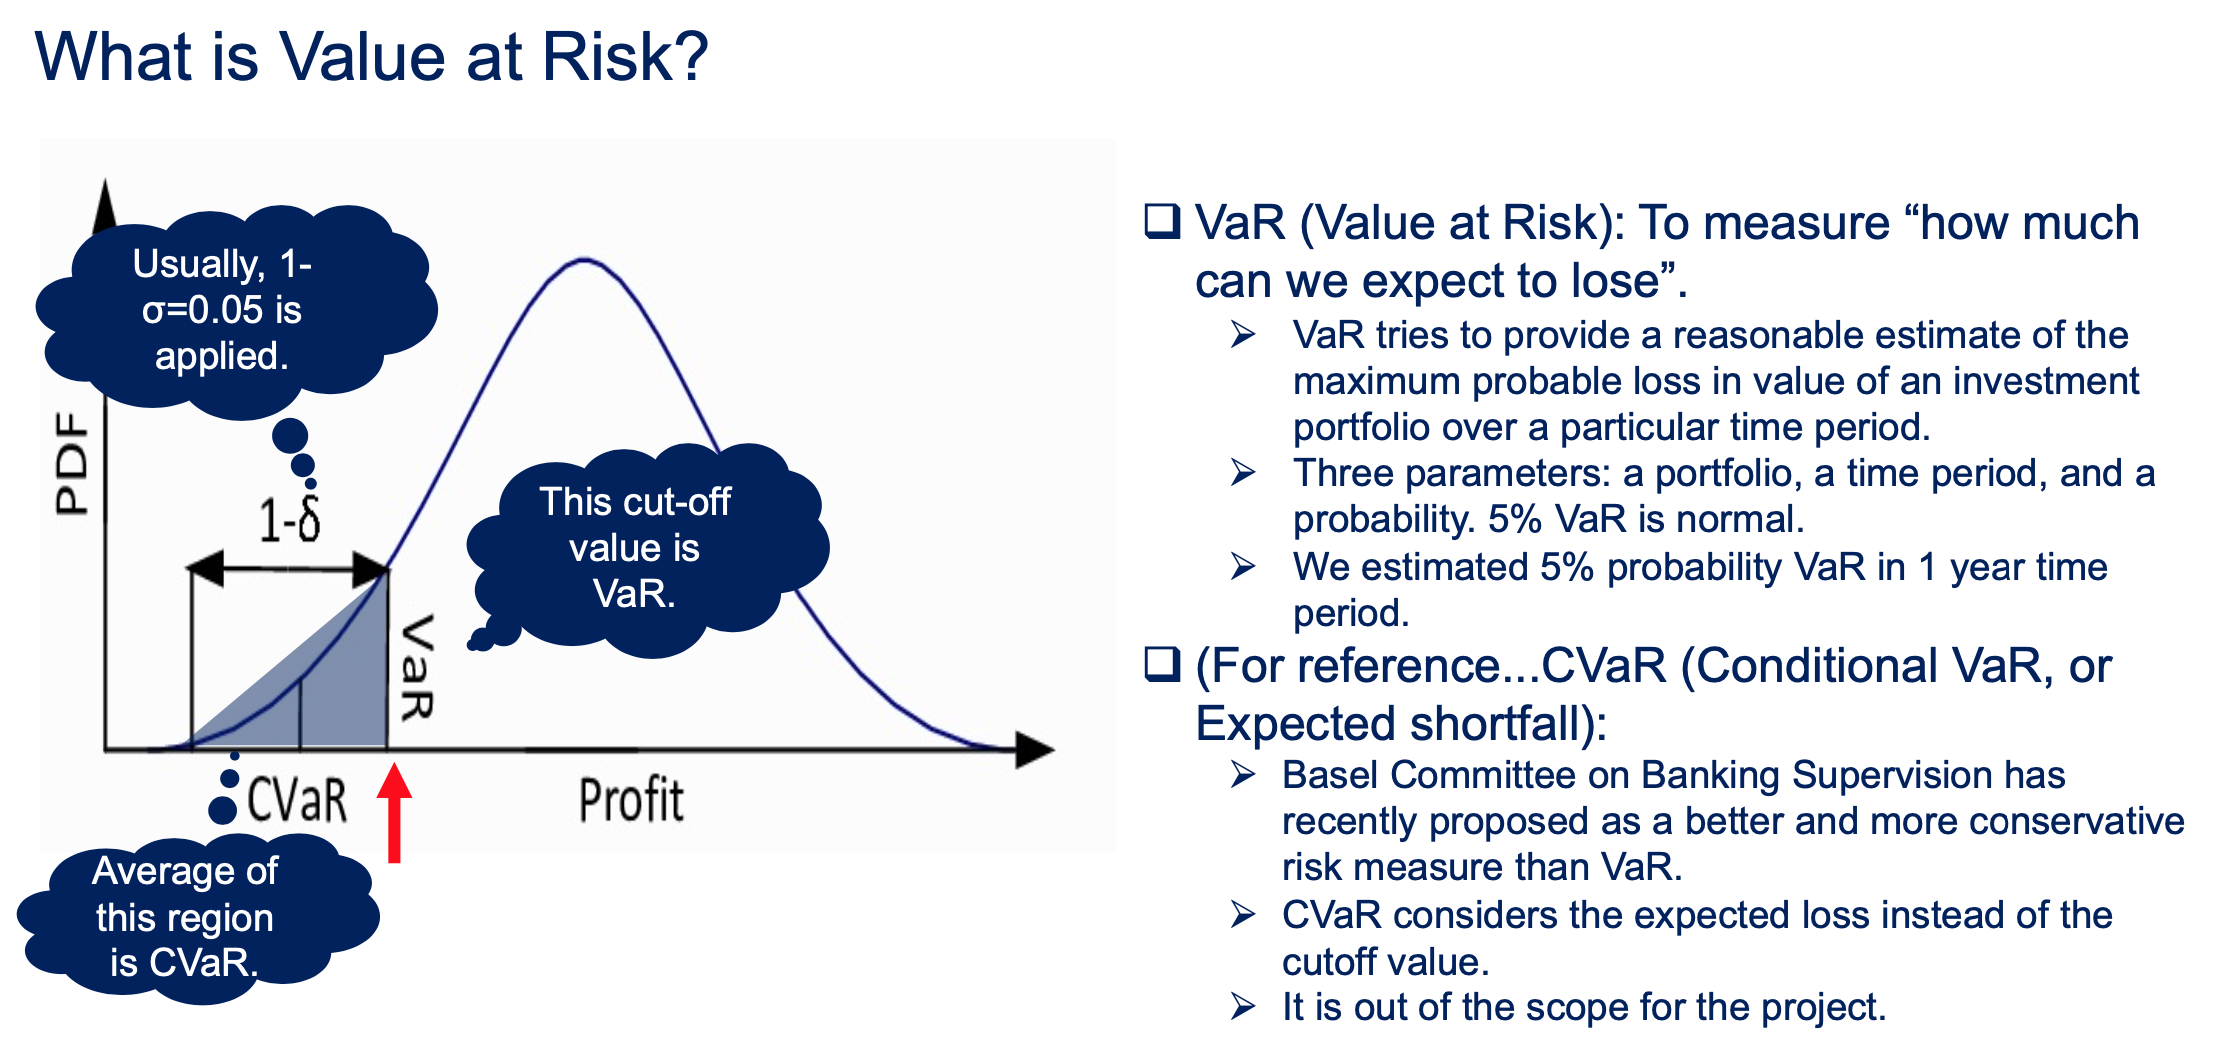

(Source: Sandy Ryza, Uri Laserson, Sean Owen, Josh Wills. Advanced Analytics with Spark. O’Reilly, 2015)

* In the risk management agent, I introduced an important concept of risk management called Value at Risk (VaR). VaR tries to provide a reasonable estimate of the maximum probable loss in value of an investment portfolio over a particular time period.

* There are 3 parameters in VaR, a portfolio, a time period, and a probability. Basically, practitioners calculate 5% VaR in a certain period (1 day, 1 month, or 1 year depending on the situation) is normal.

* Also, if you prefer more conservative risk management criteria, you can also apply CVaR, i.e. Conditional VaR, which considers the expected loss  with 5% of probability, rather than cut-off value in VaR.


There are 3 methods to implement VaR (or CVaR) as follows:

* **Variance-Covariance method:** Variance-covariance is by far the simplest and least computationally intensive method. Its model assumes that the return of each instrument is normally distributed, which allows deriving an estimate analytically just by calculating volatility of the portfolio.

* **Historical simulation method:** Historical simulation extrapolates risk from historical data by using its distribution directly instead of relying on summary statistics. For example, to determine a 95% VaR for a portfolio, we might look at that portfolio’s performance for the last 100 days and estimate the statistic as its value on the fifth-worst day as “1 day 5% VaR”. A drawback of this method is that historical data can be limited and fails to include all market scenarios such as market collapse.

* **Monte Carlo Simulation method:** Monte Carlo simulation tries to weaken the assumptions in the previous 2 methods by simulating the portfolio under random conditions. While this method is widely used in the financial risk management at banks and asset management companies, it requires much computational resources. We can utilize distributed computing such as Spark to calculate Monte Carlo VaR, while it is out of the scope for this project.

In the risk management agent, the agent calculates estimated 5% probability VaR annually i.e. in 1 year time period by variance-covariance method, because of its simple implementation and computationally cheap and fast execution.

When we apply the variance-covariance method, we need to calculate the portfolio volatility i.e. standard deviation of σ (Note: variance is the square of standard deviation). The portfolio volatility for 2 securities is shown as follows:

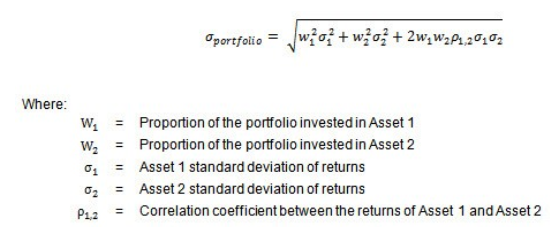

(Source:https://medium.com/python-data/assessing-the-riskiness-of-a-portfolio-with-python-6444c727c474)

* In our case, w1=cash, w2=bitcoin. Also, cash has zero volatility i.e. σ_1 = 0.

* Therefore, above equation can be simplified as follows:

 σ_portfolio = √w2^2✖️σ_2^2 = w2✖️σ_2. 

* At the functions of **def coinVaRCalc(day, var_pct=0.05)** and **def portVaRCalc(day, var_pct=0.05)** in **class riskManagement(object)**, the portfolio volatility is calculated as such.


(Note: If the portfolio can consist of multiple securities, portfolio volatility is calculated by matrix algebra shown as follows:)

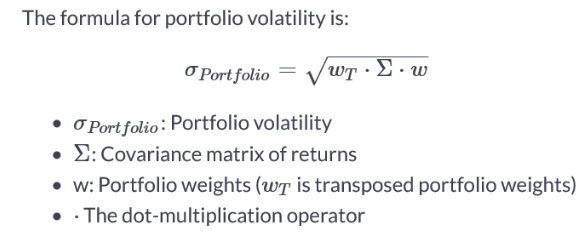

(Source:https://stackoverflow.com/questions/59462628/is-there-a-way-to-vectorize-the-portfolio-standard-deviation-in-python-pandas)

For example, above portfolio volatility of 2 securities can be shown in context of matrix algebra, as follows:

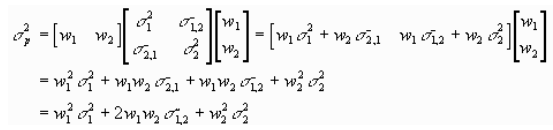

(Source:https://medium.com/python-data/assessing-the-riskiness-of-a-portfolio-with-python-6444c727c4 74)

While dealing with multiple securities or multi asset classes is out of scope this time, we can implement VaR with multiple securities or multi asset classes using the above matrix algebra formula relatively easily with Python. Also, while CVaR and monte carlo simulation methods are out of the scope in this project, it is worth introducing as those are often used by industry practitioners, such that I also introduced those just for reference.

### 2.Position sizing using VaR

* After we can calculate the portfolio of VaR, we can decide the position size using VaR. For example, the CEO agent sets the maximum VaR limit = 0.2 (20% of loss in 1 year with 5% of probability), we can take the position as such, by calculating follows:

 σ_portfolio = weight of bitcoin in total NAV*σ_bitcoin

 s.t.

 the weight of bitcoin in total NAV = σ_portfolio / σ_bitcoin.

 The system implements such a function at **def targetPositionFromVaR(day, VaRLimit, var_pct=0.05)** in in **class riskManagement(object)**. In this function, using above logic, the target bitcoin’s position size is calculated by Target Coin Value = NAV*VaR_limit / VaR_bitcoin.

* As you can infer, the bitcoin volatility σ_bitcoin can change over time as the degree of market fluctuation of bitcoin changes, such that our portfolio volatility σ_portfolio can change over time.

* The CEO function can decide the position sizing using this function, and can rebalance the portfolio using this function, i.e. if the VaR becomes too large at the current position size in terms of VaR limit, the system can slush the position size, and vice versa.

* It is the operation that many institutional investors actually do in daily portfolio management, such that I implemented such a function to introduce such basic portfolio management activities in the financial and investment management industries.

### Code of the agent

In [ ]:
class riskManagement(object):

  ##########################
  #Value At Risk related
  #risk management tools
  ##########################

  #calculate crypto's volatility and VaR, annualized
  def coinVaRCalc(day, var_pct=0.05):
    price_df = Broker.longHistoryPriceGetter()

    last_day = day
    past1m = last_day + datetime.timedelta(days=-30)
    daily_volatility = price_df.loc[(price_df.index >= past1m) & (price_df.index <= last_day),'pct_change'].std()
    #Converting daily volatility into annual volatility.
    annual_volatility = daily_volatility * np.sqrt(365)
    #Calculate 1 year VaR under var_pct=0.05 (default)
    #norm.ppf(0.95) can return standard deviation at lower 5% point in 
    #gaussian distribution. norm.ppf(0.95) = 1.65, norm.ppf(0.99)=2.32
    var_calc = - annual_volatility * norm.ppf(1-var_pct)

    return var_calc

  @staticmethod
  def portVaRCalc(day, var_pct=0.05):
    #calculate crypto's VaR
    coin_var = riskManagement.coinVaRCalc(day, var_pct=0.05)
    #check this day's coin_value, nav
    indexRow = Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day].index.values[0]
    coin_value = Account.getTradeInfoDf().loc[indexRow,'coin_value']
    nav = Account.getTradeInfoDf().loc[indexRow,'nav']
    #calculate how much % of portfolio is crypto
    coin_port_pct = coin_value / nav
    #portfolio VaR is calculated by coin_var * coin_port_pct
    port_var = coin_var * coin_port_pct

    return port_var

  @staticmethod
  def targetPositionFromVaR(day, VaRLimit, var_pct=0.05):
    #calculate crypto's VaR
    coin_var = riskManagement.coinVaRCalc(day, var_pct)
    #check yesterday's nav
    indexRow = Account.getTradeInfoDf().loc[Account.getTradeInfoDf()['time'] == day].index.values[0]
    nav = Account.getTradeInfoDf().loc[indexRow,'nav']
    #calculate target crypto's position size from CEO's VaRLimit
    target_coin_value = nav * np.abs(VaRLimit) / np.abs(coin_var)
    #check last day's coin_value, nav
    lastday_last_price = Account.getTradeInfoDf().loc[indexRow,'last_price']
    #calculate target position size
    target_num_coin = target_coin_value / lastday_last_price

    return target_num_coin

  ##########################
  #Target profit and loss tolerance related
  #risk management tools
  ##########################

  #If NAV reaches to certain loss / profit amount, CEO will decide to
  #stop trading.
  @staticmethod
  def riskManagementAssets(day,lossTolerance, profitTarget):
      initialNAV = PNLAgent.getInitialNAV()
      currentNAV = PNLAgent.getTodayNAV(day)
      PnLPercent = currentNAV / initialNAV - 1.0
      
      if PnLPercent <= lossTolerance or PnLPercent >= profitTarget:
          return True
      return False

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################

  #No data communication with another agents from backTest agent

## Example of execution of PnL Agent and VaR agent

### PnL Agent: PnL update

Account initialization

In [ ]:
Account.initialization(0,1000000,datetime.datetime(2021,1,1))

In [ ]:
Account.getTradeInfoDf()

,time,side,exec_price,last_price,cost_price,pnl_costprice,quantity,num_coins,coin_value,cash,nav,dailyPnL,dailyPnLPct,totalPnL,totalPnLPct,VaR_annualized
0,2021-01-01,no-trade,0,0,0,0,0,0,0,1000000,1000000,0,0,0,0,0


First day, no trade

In [ ]:
day = Account.getTradeInfoDf()['time'].iloc[-1]

In [ ]:
#update last_price of Account book    
PNLAgent.updateLastPrice(day)
#update NAV of Account book
PNLAgent.calculateNAV(day)

In [ ]:
Account.getTradeInfoDf()

,time,side,exec_price,last_price,cost_price,pnl_costprice,quantity,num_coins,coin_value,cash,nav,dailyPnL,dailyPnLPct,totalPnL,totalPnLPct,VaR_annualized
0,2021-01-01,no-trade,0,29374.152344,0,0,0,0,0.0,1000000,1000000.0,0,0,0,0,0


One day ahead: Buy trading

In [ ]:
day = day + datetime.timedelta(days=1)

In [ ]:
time = day

In [ ]:
side = 'buy'
exec_price = Broker.get_pseudo_ask_price(day)
#position size is determined by risk management agent.
quantity = 3.5

#temporally set as zero. Those figures are calculated later
nav = 0.0
dailyPnL = 0.0
dailyPnLPct = 0.0
totalPnL = 0.0
totalPnLPct = 0.0
VaR_annualized = 0.0

#creating today's account balance
Broker.tradeExecution(time,side, exec_price, quantity, nav, dailyPnL, 
                      dailyPnLPct, totalPnL, totalPnLPct, VaR_annualized)
#update last_price
PNLAgent.updateLastPrice(time)
#update NAV for today
PNLAgent.calculateNAV(time)

Now, using PNLAgent, PnL is updated correctly. Also, within PNLAgent, Risk Management agents' riskManagement.portVaRCalc(day) is called such that VaR_annualized is calculated correctly too.

In [ ]:
Account.getTradeInfoDf()

,time,side,exec_price,last_price,cost_price,pnl_costprice,quantity,num_coins,coin_value,cash,nav,dailyPnL,dailyPnLPct,totalPnL,totalPnLPct,VaR_annualized
0,2021-01-01,no-trade,0.000000,29374.152344,0.000000,0.000000,0.0,0.0,0.000000,1000000.00000,1000000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-01-02,buy,32159.394846,32127.267578,32159.394846,-0.000999,3.5,3.5,112445.436523,887442.11804,999887.554563,-112.445437,-0.000112,-112.445437,-0.000112,-0.124198


One day ahead: Sell trading

In [ ]:
day = day + datetime.timedelta(days=1)

In [ ]:
time = day

In [ ]:
side = 'sell'
exec_price = Broker.get_pseudo_bid_price(time)

#position size is determined by risk management agent.
quantity = 2.5

#temporally set as zero. Those figures are calculated later
nav = 0.0
dailyPnL = 0.0
dailyPnLPct = 0.0
totalPnL = 0.0
totalPnLPct = 0.0
VaR_annualized = 0.0

#creating today's account balance
Broker.tradeExecution(time,side, exec_price, quantity, nav, dailyPnL, 
                      dailyPnLPct, totalPnL, totalPnLPct, VaR_annualized)
#update last_price
PNLAgent.updateLastPrice(time)
#update NAV for today
PNLAgent.calculateNAV(time)

In [ ]:
Account.getTradeInfoDf()

,time,side,exec_price,last_price,cost_price,pnl_costprice,quantity,num_coins,coin_value,cash,nav,dailyPnL,dailyPnLPct,totalPnL,totalPnLPct,VaR_annualized
0,2021-01-01,no-trade,0.000000,29374.152344,0.000000,0.000000,0.0,0.0,0.000000,1000000.000000,1.000000e+06,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-01-02,buy,32159.394846,32127.267578,32159.394846,-0.000999,3.5,3.5,112445.436523,887442.118040,9.998876e+05,-112.445437,-0.000112,-112.445437,-0.000112,-0.124198
2,2021-01-03,sell,32749.241414,32782.023438,32159.394846,0.019361,2.5,1.0,32782.023438,969315.221575,1.002097e+06,2209.690449,0.002210,2097.245013,0.002097,-0.036122


### Risk Management agent: VaR calculation etc

#### VaR calculation of bitcoin itself

riskManagement.coinVaRCalc() calculates the VaR of bitcoin itself i.e. if we hold 100% bitcoin and 0% in cash, we can make -101.1% of loss annually with 5% of probability, based on the volatility of bitcoin.

In [ ]:
day = datetime.datetime(2021,1,1)

By default, it calculate 1 year 5% VaR, which is usually used to many industry practitioners.

In [ ]:
riskManagement.coinVaRCalc(day, var_pct=0.05)

-1.011158419571257

By changing var_pct = 0.01, it can calculate 1 year 1% VaR, which is sometimes used for industry practitioners.

In [ ]:
riskManagement.coinVaRCalc(day, var_pct=0.01)

-1.430100649167058

#### Portfolio VaR Calculation

riskManagement.portVaRCalc(day) calculates the portfolio VaR, reflecting cash position. If current portfolio is 100% cash and 0% bitcoin, VaR will become zero because cash position cannot lose any money. If 100% bitcoin and 0% cash, portfolio VaR = bitcoin VaR. If cash/bitcoin is in between, VaR is also in between.

Jan 1st, no position in Account book obtained by Account.getTradeInfoDf(), so portfolio VaR is zero. Only cash, no possibility of making loss. 

In [ ]:
riskManagement.portVaRCalc(day)

-0.0

On Jan 3, Account books owns some bitcoin position, so there is risk of making loss. Below shows that in 1 year, there is 5% of possibility that the portfolio makes -3.61% or more loss.

In [ ]:
riskManagement.portVaRCalc(datetime.datetime(2021,1,3))

-0.03612183475524433

#### Reverse engineering of maximum position size available, from VaR limit.

* riskManagement.targetPositionFromVaR() can calculate the "maximum position that we can take, in terms of VaRLimit".

* For example, in below case, the CEO set maximum VaR of portfolio should be within 0.5 i.e -50% of loss annually with 5% of probability. We can take 16.8 coins of bitcoins in this case.

* This is used for the position sizing by CEO. For example, if the bitcoin position is too large compared with the VaR limit, CEO can reduce position based on this number, and vice versa.

* Such risk management activity based on VaR is a very typical procedure for many fund managers and hedge-funds, while the methodology is more detailed in the operation of actual institutional investors.

In [ ]:
riskManagement.targetPositionFromVaR(day, VaRLimit=0.5, var_pct=0.05)

16.833927753489125

#### Trading stop trigger from making large profit or large loss

When we could reach to the target profit, we can stop trading. Also, if we reach to the maximum loss tolerance, we should stop trading not making more loss.

#### Usual case: trade continue

In [ ]:
yesterday = datetime.datetime(2021,1,3)

In [ ]:
lossTolerance = -0.5
profitTarget = 0.5

In [ ]:
####################
#Risk management:Return since inception
####################

#check total return since inception
tradeKill = riskManagement.riskManagementAssets(yesterday,
                                                  lossTolerance,
                                                  profitTarget)

In [ ]:
tradeKill

False

In [ ]:
#if return since inception reaches to max loss tolerance or profit target,
#we kill the trade.
if tradeKill == True:
  print("Now we reached to max loss / profit target. Exit trade.")

#### Special case: If we reach to lossTolerance or profitTarget, kill trade

In [ ]:
lossTolerance = -0.5
profitTarget = 0.000001

In [ ]:
#check total return since inception
tradeKill = riskManagement.riskManagementAssets(yesterday,
                                                  lossTolerance,
                                                  profitTarget)

In [ ]:
tradeKill

True

In [ ]:
#if return since inception reaches to max loss tolerance or profit target,
#we kill the trade.
if tradeKill == True:
  print("Now we reached to max loss / profit target. Exit trade.")


Now we reached to max loss / profit target. Exit trade.


## Data visualization and RPA agent

* Data visualization and RPA (Robotic Process Automation) are also important parts in business operational flow.

* By data visualization with several graphs and charts, we can recognize what’s going on in the market and our portfolio easily and can make decisions toward the market timely (such as the human decision making of whether we should stop working the trading system etc).

* Also, we can improve efficiency of daily operation by automating repetitive operations such as sending monthly reports by email and storing attached files in email to specific data storage (such as One Drive).

* This agent takes those tasks such as data visualization and RPA. I introduced PowerBI for data visualization and Power Automate for RPA. Those Microsoft products are widely used, such that we can utilize those in our workplace to improve operational efficiency.

### 1.Data visualization by PowerBI

In the data visualization tool, Tableau and PowerBI are popularly used in business corporations, and the PowerBI is the one which is released by Microsoft. With regard to the basic usage and how-to, we can refer to Microsoft’s website as follows. You can learn how to create and manage Report and Account in Power BI to visualize our data with graphs and charts.

Get started using Power BI
https://docs.microsoft.com/en-us/users/microsoftpowerplatform-5978/collections/k8xidwwnzk1em

After setting Power BI and executing below code, we can see the data updated like the following picture at the “Report” which is linked with the “Account” file.

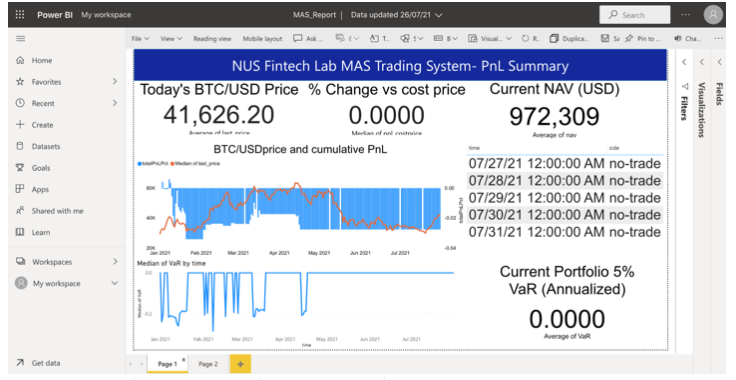

### 2.RPA by PowerAutomate

Robotic process automation (RPA) is a technology that mimics and automates the way humans interact with software to perform high-volume, repeatable tasks. While there are many RPA software and services available, Microsoft Power Automate is a convenient solution for RPA, especially as we would like to automate operations around softwares and services of Microsoft family (i.e. Office 365, One Drive etc). With regard to the basics of how-to and what we can do by Power Automate, we can refer to the following tutorials from Microsoft.

Get started with Power Automate
https://docs.microsoft.com/en-us/power-automate/getting-started

* On the other hand, unfortunately, Power Automate cannot set Google Drive and google Colab as the trigger of doing automated action.

* Also, with regard to the frequently used function such as sending email automatically, we can write code to send email automatically.

* So, I introduced the code to send email automatically at **def outlookSend(file_name)** in class **dataVisualRPA(object)**.

* As a result, the system automated the monthly report sending and storing tasks by Python code and Power Automate shown in the following picture. We can reduce the cost and improve daily efficiency significantly by RPA, such that we can utilize this skill at the daily workplace.

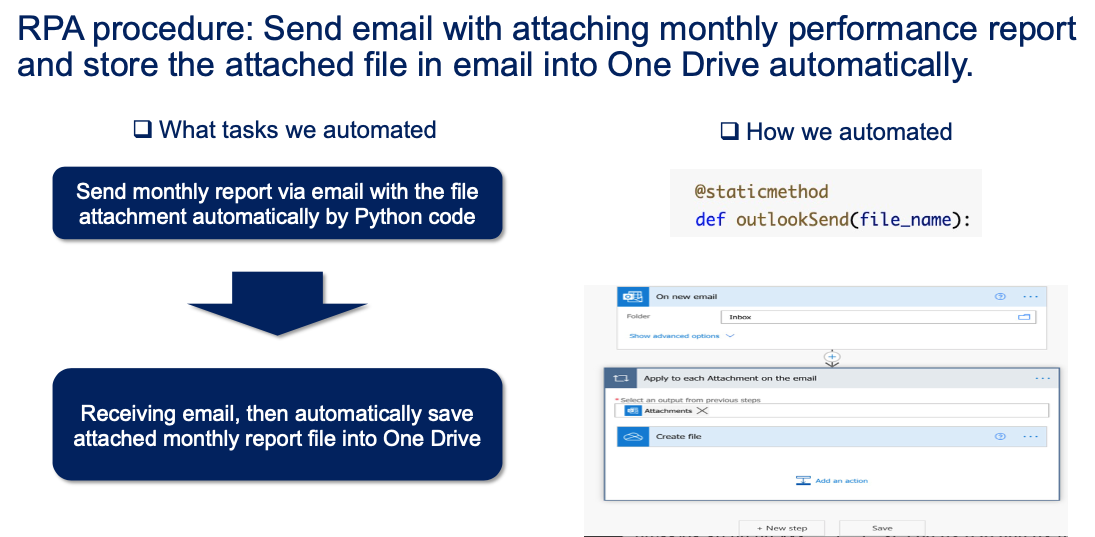

### Sample code of the agent

In [ ]:
class dataVisualRPA(object):
  
  # Visualization in PowerBI
  @staticmethod
  def visualizationPowerBI():
    #use your own PowerBI url
    url ='xxx'

    # Prepare all the data
    #Account book information
    day =Account.getTradeInfoDf()['time'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S')
    side =Account.getTradeInfoDf()['side'].iloc[-1]
    exec_price =Account.getTradeInfoDf()['exec_price'].iloc[-1].astype('float64')
    last_price =Account.getTradeInfoDf()['last_price'].iloc[-1].astype('float64')
    cost_price =Account.getTradeInfoDf()['cost_price'].iloc[-1].astype('float64')
    pnl_costprice =Account.getTradeInfoDf()['pnl_costprice'].iloc[-1].astype('float64')
    quantity =Account.getTradeInfoDf()['quantity'].iloc[-1].astype('float64')
    num_coins = Account.getTradeInfoDf()['num_coins'].iloc[-1].astype('float64')
    coin_value = Account.getTradeInfoDf()['coin_value'].iloc[-1].astype('float64')
    cash = Account.getTradeInfoDf()['cash'].iloc[-1].astype('float64')
    nav = Account.getTradeInfoDf()['nav'].iloc[-1].astype('float64')
    dailyPnL = Account.getTradeInfoDf()['dailyPnL'].iloc[-1].astype('float64')
    dailyPnLPct = Account.getTradeInfoDf()['dailyPnLPct'].iloc[-1].astype('float64')
    totalPnL = Account.getTradeInfoDf()['totalPnL'].iloc[-1].astype('float64')
    totalPnLPct = Account.getTradeInfoDf()['totalPnLPct'].iloc[-1].astype('float64')    
    VaR_annualized = Account.getTradeInfoDf()['VaR_annualized'].iloc[-1].astype('float64')

    data = [
            {"time": day,
             "side": side,
             "exec_price": exec_price,
             "last_price": last_price,
             "cost_price": cost_price,
             "pnl_costprice": pnl_costprice,
             "num_coins": num_coins,
             "nav": nav,
             "totalPnL": totalPnL,
             "totalPnLPct": totalPnLPct,
             "VaR": VaR_annualized,
             }
            ]

    headers = {"Content-Type": "application/json"}
    response = requests.request(
      method="POST",
      url= url,
      headers=headers,
      data=json.dumps(data)
    )
  
  @staticmethod
  def outlookSend(file_name):
    #set smtp host and port of outlook
    smtp_host = 'smtp.office365.com'
    smtp_port = 587
    #set email address of from and to
    from_email = 'xxxxxx@u.nus.edu'
    to_email = 'xxxxxx@u.nus.edu'
    #username and pass for "from" email address
    #enter your own NUS email and password
    username = 'xxxxxx@u.nus.edu'
    password = 'xxxxxxxxxx'

    #email contents (subject, body message, etc)
    subject = 'Performance Report, attached with ' + file_name
    body = "Attached file is the monthly performance."
    encoding = 'utf-8'
    msg = MIMEMultipart()
    msg['Subject'] = subject
    msg['From'] = from_email
    msg['To'] = to_email
    msg.attach(MIMEText(body, 'plain', encoding))

    #Attach csv file to email
    #File attachment
    file_path = 'data_sendmail/' + file_name
    attach = MIMEBase('application','csv')
    with open(file_path, "br") as f:
        attach.set_payload(f.read())
    encoders.encode_base64(attach)
    attach.add_header('Content-Disposition', 'attachment',
        filename= file_name)
    msg.attach(attach)

    #establish the connection with smtp server
    server = smtplib.SMTP(smtp_host, smtp_port)
    server.ehlo()
    server.starttls()
    server.ehlo()
    #login into "from" email account with username and password
    server.login(username, password)
    #send email
    server.send_message(msg)
    #close the connection with server
    server.quit()

  @staticmethod
  def sendMonthlyReport(day):
    #set monthly data scope within this month
    monthly_account_df = Account.getTradeInfoDf()[(Account.getTradeInfoDf()['time'] >= datetime.datetime(day.year,day.month,1))\
                                               & (Account.getTradeInfoDf()['time'] <= day)]
    #set fila name based on the day of month-end
    file_name = 'MonthlyReport_' + day.strftime('%Y%m%d') + '.csv'
    #create csv file
    monthly_account_df.to_csv('data_sendmail/' + file_name)
    #send csv file
    dataVisualRPA.outlookSend(file_name)

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################

  #No data communication with another agents from backTest agent

* By executing above code, you can send Account data into PowerBI. Also, you can send Account's book file via email.

* You can use this code as a sample. By modifying above code, you can visualize your own data and automate as you would like to.